## Import external libraries. 

In [1]:
import  torch;
import  matplotlib.pyplot   as plt;
import  matplotlib          as mpl;
import  colorsys;
import  seaborn;
from    typing              import  List, Dict, Tuple;
from    scipy               import  interpolate;
import  numpy;

## Import my code

### Model Class

Define a class that can describe the right-hand side of a DDE, 
$$x'(t) = F(x(t), y(t), t) $$

In our case, the right-hand side we want to learn will be
1. $F(x, y, t) = x(1 - y) $
2. $F(x, y, t) = \sin{x}$

The `MODEL` class defines an object that can act like the function $F$.

### DDE Solver

This is an algorithm to solve a DDE of the following form:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$

We find an approximate solution using a forward euler solver for DDEs.

### NDDE class

Here we define the `NDDE_1D` class. This class acts as a wrapper around a `MODEL` object. Recall that a `MODEL` object acts like the function $F$ in the following DDE:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$
The `NDDE_1D` class accepts a `MODEL`. Its forward method solves the implied DDE on the interval $[0, T]$ and then returns the result.

### Loss

The Loss_Fn defines the loss we try to minimize. Currently, this is just the MSE between the predicted and target trajectory.

In [2]:
from    MODEL   import  Logistic_Model      as MODEL;
from    Solver  import  RK2                 as DDE_Solver;
from    NDDE    import  NDDE_1D;
from    Loss    import  SSE_Loss            as Loss_Fn;
from    Loss    import  l;

### Generate Target Trajectory

Generate the target trajectory and plot it!

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Computer Modern Sans Serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Computer Modern Sans Serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Computer Modern Sans Serif


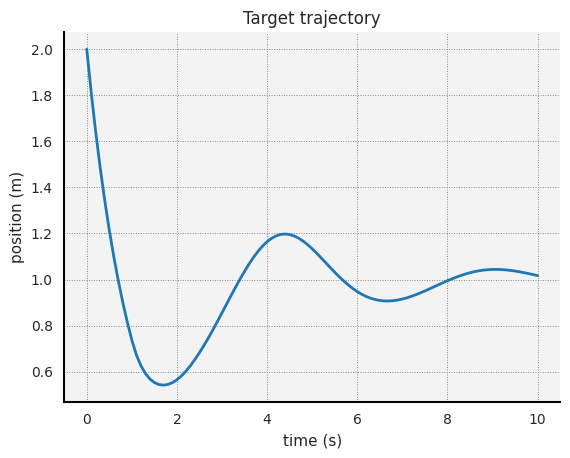

In [3]:
# Set up the parameters and tau value for the target trajectory.
F_Target        = MODEL(theta_0 = 1.0, theta_1 = 1.0);
x_0_Target      = torch.tensor([2.0]);
tau_Target      = torch.tensor(1.0);
T_Target        = torch.tensor(10.0);

# Get the target trajectory!
x_Trajectory_Target, t_Trajectory_Target  = DDE_Solver(F = F_Target, x_0 = x_0_Target, tau = tau_Target, T = T_Target);


# Now... let's set up plot formatting.
def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)

    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

seaborn.set_context(context     = "paper");
seaborn.set_style(  style       = "darkgrid");
mpl.rcParams["lines.linewidth"] = 2;
mpl.rcParams["axes.linewidth"]  = 1.5;
mpl.rcParams["axes.edgecolor"]  = "black";
mpl.rcParams["grid.color"]      = "gray";
mpl.rcParams["grid.linestyle"]  = "dotted";
mpl.rcParams["grid.linewidth"]  = .67;
mpl.rcParams["font.sans-serif"] = "Computer Modern Sans Serif"
mpl.rcParams["xtick.labelsize"] = 10;
mpl.rcParams["ytick.labelsize"] = 10;
mpl.rcParams["axes.labelsize"]  = 11;
mpl.rcParams["axes.titlesize"]  = 12;
mpl.rcParams["axes.facecolor"]  = scale_lightness(mpl.colors.ColorConverter.to_rgb("lightgrey"), 1.15);

# Finally, lets plot the target trajectory.
seaborn.lineplot(x = t_Trajectory_Target.detach().numpy(), y = x_Trajectory_Target.reshape(-1).detach().numpy());
seaborn.despine();
plt.xlabel("time (s)");
plt.ylabel("position (m)");
plt.title("Target trajectory");

### Setup, train the Model 


In [4]:
# Set up a NDDE_1D object. We will try to train the enclosed model to match the one we used to generate the above plot.
Model       = MODEL(theta_0 = 1.75, theta_1 = 1.75);
DDE_Module  = NDDE_1D(Model);

# Pick a starting position, tau, and x_0
tau     = torch.tensor(1.75,     requires_grad = True);
x_0     = torch.clone(x_0_Target).requires_grad_(True);
T       = torch.clone(T_Target).requires_grad_(False);

# Select the optimizer, number of epochs.
Param_List  : List  = list(Model.parameters()) + [tau];
Optimizer           = torch.optim.Adam(Param_List, lr = 0.1);
N_Epochs    : int   = 1000;

# Set up buffers to track history of loss, and tau.
History_Dict : Dict[str, torch.Tensor] = {};
History_Dict["Loss"]    = torch.zeros(N_Epochs);
History_Dict["tau"]     = torch.zeros(N_Epochs);

# Set up an interpolation for the target trajectory. We will need to evaluate this 
# wherever we evaluate the predicted trajectory
x_Target_Interp                         = interpolate.interp1d(t_Trajectory_Target.detach().numpy(), x_Trajectory_Target.detach().numpy());

# Now, run the epochs!
for epoch in range(N_Epochs):    
    # find the predicted trajectories with current tau, parameter values.
    Predicted_Trajectory : torch.Tensor = DDE_Module(x_0, tau, T, l, x_Target_Interp);

    if torch.any(torch.isnan(Predicted_Trajectory)) == False:
        # find the time steps for the output trajectory
        N : int = Predicted_Trajectory.shape[1];

        # interpolate the target solution at the new time steps. Note that we need to do 
        # this  every epoch because tau changes each epoch, and tau controls the step size.
        t_Values_np         : numpy.ndarray = numpy.linspace(start = 0, stop = T.item(), num = N);
        Target_Trajectory   : torch.Tensor  = torch.from_numpy(x_Target_Interp(t_Values_np));

        # Compute the loss!
        Loss : torch.Tensor = Loss_Fn(Predicted_Trajectory, Target_Trajectory, torch.from_numpy(t_Values_np));

        # Check if loss is low enough to stop
        if Loss < 0.001:
            print("converged after %d epochs" % epoch);
            break;

        # Otherwise, run one step of the optimizer!
        Optimizer.zero_grad();
        Loss.backward();
        Optimizer.step();

        # Report loss and stuff.
        if epoch % 10 == 0:
            print(  "%4d: "                         % epoch,
                    " Loss = %7.5f"                 % Loss.item(), 
                    " | tau = %7.5f"                % tau.item(), 
                    " | grad tau = %9.5f"           % tau.grad.item(),
                    " | Params = %7.5f, %7.5f"      % (DDE_Module.Model.Params[0], DDE_Module.Model.Params[1]), 
                    " | grad Params = %9.5f, %9.5f" % (DDE_Module.Model.Params.grad[0], DDE_Module.Model.Params.grad[1]));
            #plt.plot(Predicted_Trajectory[0].detach().numpy());

        # save the data for printing later
        History_Dict["Loss"][epoch]         = Loss.item();
        History_Dict["tau"][epoch]          = tau.item();

    else:    
        print("Something went wrong :(");
        break;

# Report final tau, parameter values.
print("Final values:");
print("tau = %7.5f, c_0 = %7.5f, c_1 = %7.5f" % (tau.item(), DDE_Module.Model.Params[0], DDE_Module.Model.Params[1]));

   0:   Loss = 93.79249  | tau = 1.65000  | grad tau =  77.55865  | Params = 1.65000, 1.65000  | grad Params = 1235.50793, 1667.12292
  10:   Loss = 27.17834  | tau = 1.66128  | grad tau =  33.61859  | Params = 1.07170, 1.13271  | grad Params =  75.24075,  58.57884
  20:   Loss = 4.65152  | tau = 1.47042  | grad tau =  11.51762  | Params = 0.72210, 0.85971  | grad Params =   1.64651, -21.38988
  30:   Loss = 7.72371  | tau = 1.27175  | grad tau =   0.33237  | Params = 0.58879, 0.82284  | grad Params = -18.68832, -70.01467
  40:   Loss = 3.51959  | tau = 1.18588  | grad tau =   0.49924  | Params = 0.59223, 0.94417  | grad Params = -18.63545, -31.52634
  50:   Loss = 1.96230  | tau = 1.13925  | grad tau =   2.09812  | Params = 0.65134, 1.05782  | grad Params = -12.21559,  -3.90917
  60:   Loss = 1.99637  | tau = 1.08154  | grad tau =   2.49963  | Params = 0.71576, 1.10715  | grad Params =  -8.01084,   6.72273
  70:   Loss = 1.59630  | tau = 1.01839  | grad tau =   0.99442  | Params = 0.7

### Plot results 

We plot the loss history, final vs true trajectory, and the loss function for fixed parameter values as a function of $\tau$

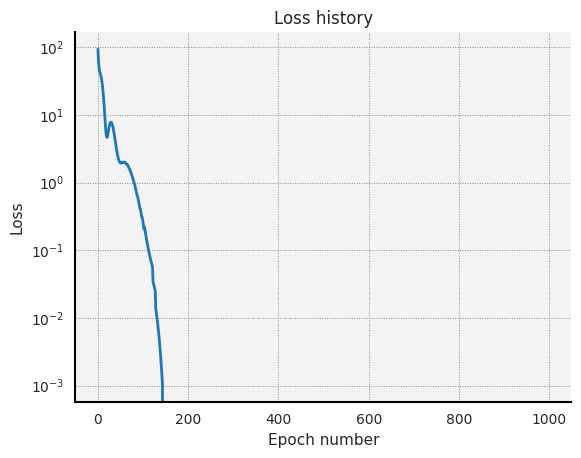

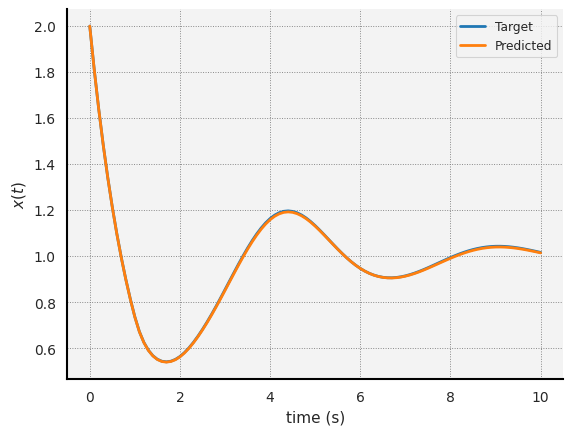

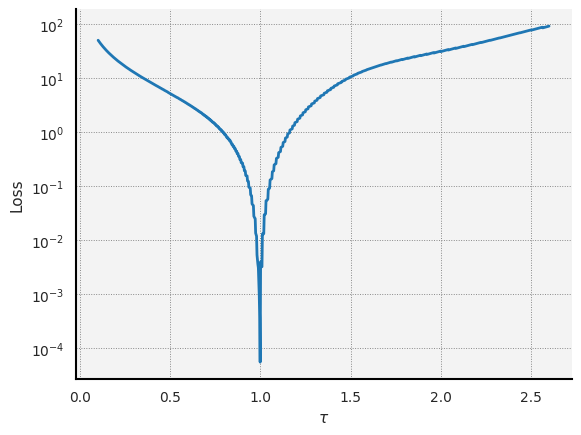

In [11]:
####################################################################################################
# Lost loss history

plt.figure(0);
plt.plot(History_Dict["Loss"].detach().numpy());
seaborn.despine();
plt.xlabel("Epoch number");
plt.ylabel("Loss");
plt.yscale("log");
plt.title("Loss history");



####################################################################################################
# Plot target, final trajectory

plt.figure(1);
plt.plot(t_Trajectory_Target, x_Trajectory_Target[0].detach().numpy(),      label = "true");
plt.plot(t_Values_np,       Predicted_Trajectory[0].detach().numpy(),   label = "discovered");
seaborn.despine();
plt.xlabel("time (s)");
plt.ylabel(r"$x(t)$");
plt.legend(["Target","Predicted"]);



####################################################################################################
# Plot loss as a function of tau

# Build initial model
G : MODEL = MODEL(theta_0 = 1.0, theta_1 = 1.0);

# Set up a grid of tau values. We will find the loss at each one.
N_Steps : int = 1000;
grid_tau = torch.linspace(0.1, 2.6, steps = N_Steps, requires_grad = True);
Loss_tau = torch.zeros(N_Steps);

for i in range(N_Steps):
    # Find predictions for ith tau value.
    Predictions_i : torch.Tensor = DDE_Solver(G, x_0, grid_tau[i], T)[0];

    # Interpolate true solution on the time step grid for this solution.
    N_i                 : int           = Predictions_i.shape[1];
    x_Interp                            = interpolate.interp1d(t_Trajectory_Target.detach().numpy(), x_Trajectory_Target.detach().numpy());
    t_Values            : numpy.ndarray = numpy.linspace(start = 0, stop = T.item(), num = N_i);
    Targets_i           : torch.Tensor  = torch.from_numpy(x_Interp(t_Values));
    
    # Compute loss
    Loss_tau[i] = Loss_Fn(Predictions_i, Targets_i, t_Values);

# Plot!
plt.figure(2);
seaborn.lineplot(x = grid_tau.detach().numpy(), y = Loss_tau.detach().numpy());
seaborn.despine();
plt.xlabel(r"$\tau$");
plt.ylabel("Loss");
plt.yscale("log");